Following [this](https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning) post.

In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [57]:
google_train_base = pd.read_csv("./Google_train_data.csv")

In [122]:
google_train_base.shape

(1258, 6)

In [58]:
google_train_base.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


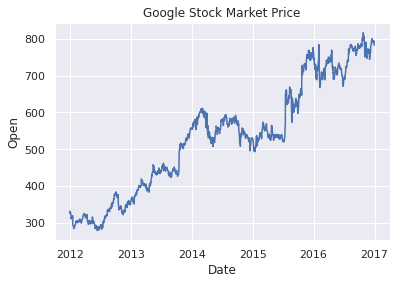

In [59]:
import datetime
import seaborn as sns
sns.set_theme(style="darkgrid")

plot_me_base =  google_train_base.copy()
plot_me_base.Date = plot_me_base.Date.map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))
sns.lineplot(x=plot_me_base.Date, y=plot_me_base.Open)
plt.title('Google Stock Market Price')
plt.show()

In [60]:
# We will be using Open Stock to train or model.
training_set = google_train_base.iloc[:, 1:2].values

_Sena's Comment_

Two things about this dataset, obviously the date is not day by day, since we have days that the stock market are closed.

This model ignore those days, thinking it as only an continous line and doesn't cares about date at all.

In [61]:
training_set[:5]

array([[325.25],
       [331.27],
       [329.83],
       [328.34],
       [322.04]])

In [62]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_training_set = scaler.fit_transform(training_set)
scaled_training_set[:5]

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       [0.09156187],
       [0.07984225]])

_Sena's comment_

Read why is necessary use a Scaler here... Why prices should be scaled?

Because we are using an RNN, since that we need a fast convergency?

In [63]:
# To get regular value for transformed data.
scaler.inverse_transform(scaled_training_set[:5])

array([[325.25],
       [331.27],
       [329.83],
       [328.34],
       [322.04]])

In [64]:
scaled_training_set.shape
scaled_training_set[2]

array([0.09433366])

_Sena's comment_

From here now, we start to be "cabuloso", bc why do we need those shapes in the data

In [65]:
# Now thats a weird part. We should get X_train and y_train... But isn't this dataset only numbers? Or like a Time Series?
X_train = []
y_train = []
# Magical Numbers... Why?

# First: The shape of scaled_training_set: (1258, 1) 

# Why 60? Looks like 60 time-steps which is the RNN memory (like 60 characters)
for i in range(60, 1258):
    X_train.append(scaled_training_set[i-60:i, 0])
    y_train.append(scaled_training_set[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(1198, 60)
(1198,)


In [66]:
# Now we reshape the data.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


# Why do we need the data to be in this shape?
X_train.shape

(1198, 60, 1)

In [67]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [68]:
# Creating regressor
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(.2))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')

In [69]:
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 [==============================] - 11s 77ms/step - loss: 0.0308
Epoch 2/100
38/38 [==============================] - 3s 75ms/step - loss: 0.0069
Epoch 3/100
38/38 [==============================] - 3s 76ms/step - loss: 0.0058
Epoch 4/100
38/38 [==============================] - 3s 73ms/step - loss: 0.0059
Epoch 5/100
38/38 [==============================] - 3s 75ms/step - loss: 0.0062
Epoch 6/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0048
Epoch 7/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0044
Epoch 8/100
38/38 [==============================] - 3s 74ms/step - loss: 0.0041
Epoch 9/100
38/38 [==============================] - 3s 69ms/step - loss: 0.0047
Epoch 10/100
38/38 [==============================] - 3s 68ms/step - loss: 0.0054
Epoch 11/100
38/38 [==============================] - 3s 72ms/step - loss: 0.0042
Epoch 12/100
38/38 [==============================] - 3s 78ms/step - loss: 0.0049
Epoch 13/100
38/38 [====

In [70]:
test_base = pd.read_csv('Google_test_data.csv')

test_stock_price = test_base.iloc[:, 1:2].values

In [88]:
test_base.shape

(252, 7)

In [102]:
total_ds = pd.concat((google_train_base.Open, test_base.Open), axis=0)

# Again the 60 magic number... Identify why: 60 its the time-step
inputs = total_ds[len(total_ds) - len(test_base) - 60:].values

inputs = np.reshape(inputs, (-1, 1))
inputs = scaler.transform(inputs)
inputs.shape

(312, 1)

In [134]:
X_test = []
# Wtf are those numbers??: 60 is the time-step in RNN 312 ITS THE INPUT LENGHT
for i in range(60, 312):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [114]:
np.array([ [ [1],[1] ], [ [2],[2] ], [ [1],[1] ], [ [2],[2] ] ]).shape

(4, 2, 1)

In [105]:
predicted_value = regressor.predict(X_test)
predicted_value = scaler.inverse_transform(predicted_value)

predicted_value.shape

(252, 1)

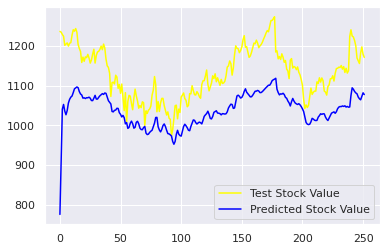

In [136]:
plt.plot(test_stock_price, color='yellow', label='Test Stock Value')
plt.plot(predicted_value, color='blue', label='Predicted Stock Value')
plt.legend()